## train embedding layer

In [29]:
# load IMDB dataset as 2D int tensor of shape (samples, max_len)
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 10_000
max_len = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [12]:
# build and train simple classifier network with an embedding layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_features, 8, input_length=max_len))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_5 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
  8/625 [..............................] - ETA: 4s - loss: 0.6926 - acc: 0.4922  

2022-11-27 13:00:26.569711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


624/625 [============================>.] - ETA: 0s - loss: 0.6691 - acc: 0.6120

2022-11-27 13:00:30.474581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 5s 7ms/step - loss: 0.6690 - acc: 0.6122 - val_loss: 0.6121 - val_acc: 0.7024
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5347 - acc: 0.7515 - val_loss: 0.5184 - val_acc: 0.7308
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4590 - acc: 0.7865 - val_loss: 0.4976 - val_acc: 0.7436
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4256 - acc: 0.8045 - val_loss: 0.4909 - val_acc: 0.7518
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4033 - acc: 0.8179 - val_loss: 0.4933 - val_acc: 0.7536
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3851 - acc: 0.8291 - val_loss: 0.4955 - val_acc: 0.7562
Epoch 7/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3686 - acc: 0.8391 - val_loss: 0.5014 - val_acc: 0.7568
Epoch 8/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3528 - acc:

## use pretrained embedding layer

In [109]:
# load IMDB train dataset as raw text
# (data from http://mng.bz/0tIo)
import os

train_dir = os.path.join(os.getcwd(), 'aclImdb/train')

texts = []
labels = []

label_types = {'neg': 0, 'pos': 1}

for label_type in label_types:
    dir_name = os.path.join(train_dir, label_type)
    for file_name in os.listdir(dir_name):
        file = open(os.path.join(dir_name, file_name))
        texts.append(file.read())
        file.close()
        labels.append(label_types[label_type])

In [111]:
# tokenize text, create training / validation sets
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100 # first 100 words of each review
training_samples = 200
validation_samples = 10_000
max_words = 10_000 # only keep most common tokens

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print(f'found {len(word_index)} unique tokens')

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('shape of data tensor:', data.shape)
print('shape of labels tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]
print('shpae of x_train:', x_train.shape)
print('shpae of y_train:', y_train.shape)
print('shpae of x_val', x_val.shape)
print('shpae of y_val:', y_val.shape)

found 88582 unique tokens
shape of data tensor: (25000, 100)
shape of labels tensor: (25000,)
shpae of x_train: (200, 100)
shpae of y_train: (200,)
shpae of x_val (10000, 100)
shpae of y_val: (10000,)


In [112]:
# load GloVe word-embeddings
# (from https://nlp.stanford.edu/projects/glove)
glove_dir = os.path.join(os.getcwd(), 'glove.6B')

embeddings_index = {}
file = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
file.close()

print(f'found {len(embeddings_index)} word vectors')

found 400000 word vectors


In [113]:
# build embedding matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in list(word_index.items())[:max_words-1]:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### pretrained embeddings (200 training samples)

In [114]:
# build model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_9 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [115]:
# load pretrained word embeddings into embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [116]:
# train model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10


2023-02-20 18:58:00.040415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 2.0826 - acc: 0.5350

2023-02-20 18:58:00.425162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 267ms/step - loss: 2.0826 - acc: 0.5350 - val_loss: 0.7455 - val_acc: 0.4996
Epoch 2/10
7/7 [==============================] - 1s 228ms/step - loss: 0.5724 - acc: 0.6700 - val_loss: 0.7148 - val_acc: 0.5156
Epoch 3/10
7/7 [==============================] - 1s 210ms/step - loss: 0.5101 - acc: 0.7800 - val_loss: 0.6876 - val_acc: 0.5547
Epoch 4/10
7/7 [==============================] - 1s 210ms/step - loss: 0.3488 - acc: 0.8800 - val_loss: 0.7222 - val_acc: 0.5296
Epoch 5/10
7/7 [==============================] - 1s 207ms/step - loss: 0.4276 - acc: 0.7950 - val_loss: 0.8378 - val_acc: 0.5321
Epoch 6/10
7/7 [==============================] - 1s 209ms/step - loss: 0.1759 - acc: 0.9750 - val_loss: 0.8601 - val_acc: 0.5107
Epoch 7/10
7/7 [==============================] - 1s 224ms/step - loss: 0.1063 - acc: 1.0000 - val_loss: 0.7118 - val_acc: 0.5788
Epoch 8/10
7/7 [==============================] - 1s 209ms/step - loss: 0.0827 - acc: 1.0000 - val_lo

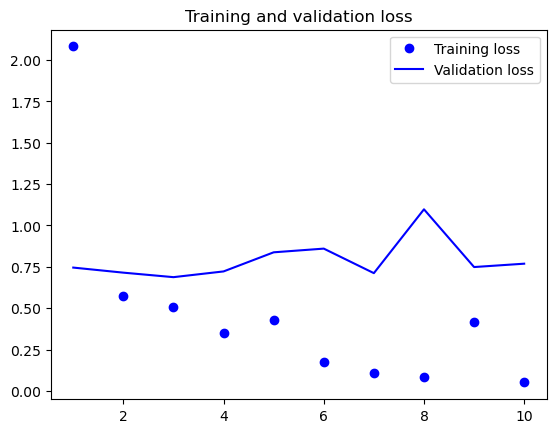

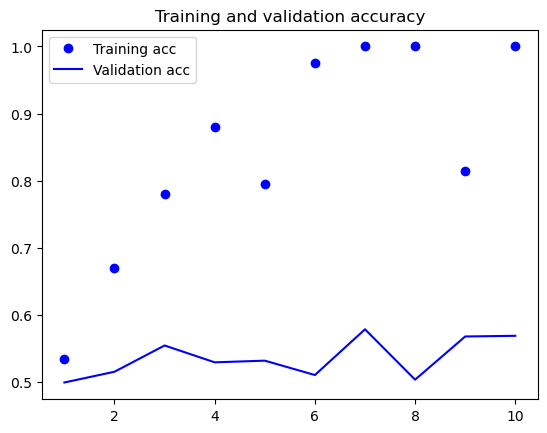

In [117]:
# plot training / validation loss and accuracy\
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### trained from scratch embeddings (200 training samples)

In [118]:
# same model without pretrained and frozen embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10


2023-02-20 19:02:14.401261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.6939 - acc: 0.5250

2023-02-20 19:02:15.004196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 290ms/step - loss: 0.6939 - acc: 0.5250 - val_loss: 0.6917 - val_acc: 0.5213
Epoch 2/10
7/7 [==============================] - 1s 231ms/step - loss: 0.4636 - acc: 1.0000 - val_loss: 0.7018 - val_acc: 0.5142
Epoch 3/10
7/7 [==============================] - 1s 232ms/step - loss: 0.2412 - acc: 0.9900 - val_loss: 0.7253 - val_acc: 0.5091
Epoch 4/10
7/7 [==============================] - 1s 208ms/step - loss: 0.1050 - acc: 1.0000 - val_loss: 0.7064 - val_acc: 0.5193
Epoch 5/10
7/7 [==============================] - 1s 210ms/step - loss: 0.0460 - acc: 1.0000 - val_loss: 0.7127 - val_acc: 0.5222
Epoch 6/10
7/7 [==============================] - 1s 208ms/step - loss: 0.0245 - acc: 1.0000 - val_loss: 0.7143 - val_acc: 0.5208
Epoch 7/10
7/7 [==============================] - 1s 218ms/step - loss: 0.0137 - acc: 1.0000 - val_loss: 0.7202 - val_acc: 0.5238
Epoch 8/10
7/7 [==============================] - 1s 231ms/step - loss: 0.0081 - acc: 1.0000 - val_lo

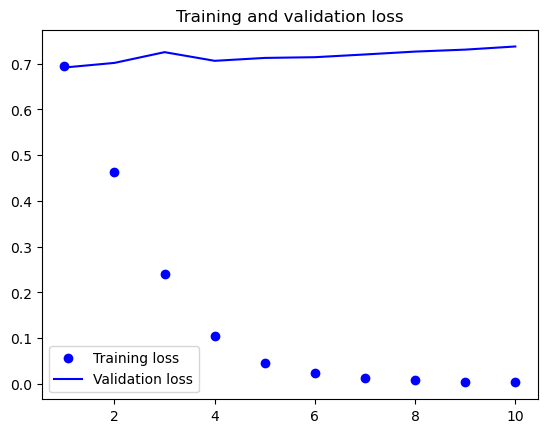

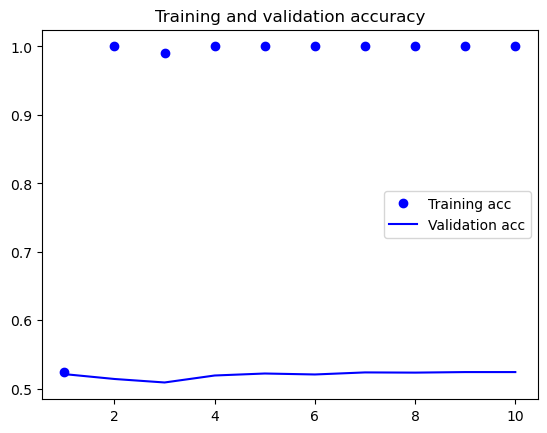

In [119]:
# plot training / validation loss and accuracy\
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### trained from scratch embeddings (2000 training samples)

In [120]:
# increase training examples
training_samples = 2000

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples + validation_samples]
y_val = labels[training_samples : training_samples + validation_samples]

In [121]:
# same model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
 1/63 [..............................] - ETA: 18s - loss: 0.6924 - acc: 0.5312

2023-02-20 19:04:28.399083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - ETA: 0s - loss: 0.6821 - acc: 0.5700

2023-02-20 19:04:29.505721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 3s 40ms/step - loss: 0.6821 - acc: 0.5700 - val_loss: 0.6526 - val_acc: 0.6512
Epoch 2/10
63/63 [==============================] - 2s 31ms/step - loss: 0.2876 - acc: 0.9595 - val_loss: 0.5579 - val_acc: 0.7116
Epoch 3/10
63/63 [==============================] - 2s 34ms/step - loss: 0.0334 - acc: 0.9975 - val_loss: 0.5688 - val_acc: 0.7179
Epoch 4/10
63/63 [==============================] - 2s 32ms/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.6005 - val_acc: 0.7320
Epoch 5/10
63/63 [==============================] - 2s 31ms/step - loss: 1.8267e-04 - acc: 1.0000 - val_loss: 0.6636 - val_acc: 0.7354
Epoch 6/10
63/63 [==============================] - 2s 29ms/step - loss: 1.2395e-05 - acc: 1.0000 - val_loss: 0.6969 - val_acc: 0.7439
Epoch 7/10
63/63 [==============================] - 2s 33ms/step - loss: 1.3733e-06 - acc: 1.0000 - val_loss: 0.7603 - val_acc: 0.7434
Epoch 8/10
63/63 [==============================] - 2s 35ms/step - loss: 2.5442e-0

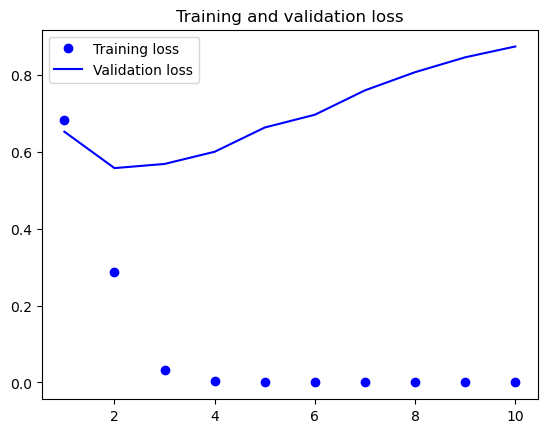

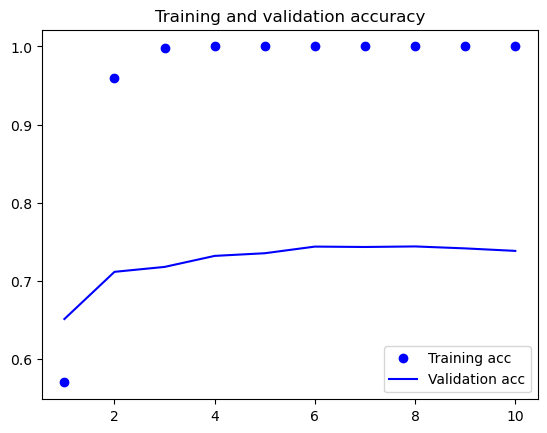

In [122]:
# plot training / validation loss and accuracy
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

### evaluate pretrained embeddings model on test data

In [123]:
# load IMDB test dataset as raw text
import os

train_dir = os.path.join(os.getcwd(), 'aclImdb/test')

texts = []
labels = []

label_types = {'neg': 0, 'pos': 1}

for label_type in label_types:
    dir_name = os.path.join(train_dir, label_type)
    for file_name in os.listdir(dir_name):
        file = open(os.path.join(dir_name, file_name))
        texts.append(file.read())
        file.close()
        labels.append(label_types[label_type])

In [124]:
# create test data and labels
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [125]:
# evaluate pretrained embeddings model
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.7797 - acc: 0.5576


[0.7796605229377747, 0.5575600266456604]